# CSI-Activity-Recognition

Human Activity Recognition using Channel State Information for Wifi Applications

A simple Tensorflow 2.0+ model using Bidirectional LSTM stacked with one Attention Layer.

This code extends the previsous work of paper [A Survey on Behaviour Recognition Using WiFi Channel State Information](http://ieeexplore.ieee.org/document/8067693/) ([corresponding code](https://github.com/ermongroup/Wifi_Activity_Recognition)).

## Dataset Preparation

Download the public dataset from [here](https://drive.google.com/file/d/19uH0_z1MBLtmMLh8L4BlNA0w-XAFKipM/view?usp=sharing).

In [ ]:
"""
The Codes in this file are used to classify Human Activity using Channel State Information. 
The deep learning architecture used here is Bidirectional LSTM stacked with One Attention Layer.
Author: https://github.com/ludlows
2019-12
"""
import numpy as np 
import tensorflow as tf
import glob
import os
import csv


def merge_csi_label(csifile, labelfile, win_len=1000, thrshd=0.6, step=200):
    """
    Merge CSV files into a Numpy Array  X,  csi amplitude feature
    Returns Numpy Array X, Shape(Num, Win_Len, 90)
    Args:
        csifile  :  str, csv file containing CSI data
        labelfile:  str, csv fiel with activity label 
        win_len  :  integer, window length
        thrshd   :  float,  determine if an activity is strong enough inside a window
        step     :  integer, sliding window by step
    """
    activity = []
    with open(labelfile, 'r') as labelf:
        reader = csv.reader(labelf)
        for line in reader:
            label  = line[0]
            if label == 'NoActivity':
                activity.append(0)
            else:
                activity.append(1)
    activity = np.array(activity)
    csi = []
    with open(csifile, 'r') as csif:
        reader = csv.reader(csif)
        for line in reader:
            line_array = np.array([float(v) for v in line])
            # extract the amplitude only
            line_array = line_array[1:91]
            csi.append(line_array[np.newaxis,...])
    csi = np.concatenate(csi, axis=0)
    assert(csi.shape[0] == activity.shape[0])
    # screen the data with a window
    index = 0
    feature = []
    while index + win_len <= csi.shape[0]:
        cur_activity = activity[index:index+win_len]
        if np.sum(cur_activity)  <  thrshd * win_len:
            index += step
            continue
        cur_feature = np.zeros((1, win_len, 90))
        cur_feature[0] = csi[index:index+win_len, :]
        feature.append(cur_feature)
        index += step
    return np.concatenate(feature, axis=0)


def extract_csi_by_label(raw_folder, label, labels, save=False, win_len=1000, thrshd=0.6, step=200):
    """
    Returns all the samples (X,y) of "label" in the entire dataset
    Args:
        raw_foler: The path of Dataset folder
        label    : str, could be one of labels
        labels   : list of str, ['bed', 'fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']
        save     : boolean, choose whether save the numpy array 
        win_len  :  integer, window length
        thrshd   :  float,  determine if an activity is strong enough inside a window
        step     :  integer, sliding window by step
    """
    print('Starting Extract CSI for Label {}'.format(label))
    label = label.lower()
    if not label in labels:
        raise ValueError("The label {} should be among 'bed','fall','pickup','run','sitdown','standup','walk'".format(labels))
    
    data_path_pattern = os.path.join(raw_folder, 'input_*' + label + '*.csv')
    input_csv_files = sorted(glob.glob(data_path_pattern))
    annot_csv_files = [os.path.basename(fname).replace('input_', 'annotation_') for fname in input_csv_files]
    annot_csv_files = [os.path.join(raw_folder, fname) for fname in annot_csv_files]
    feature = []
    index = 0
    for csi_file, label_file in zip(input_csv_files, annot_csv_files):
        index += 1
        if not os.path.exists(label_file):
            print('Warning! Label File {} doesn\'t exist.'.format(label_file))
            continue
        feature.append(merge_csi_label(csi_file, label_file, win_len=win_len, thrshd=thrshd, step=step))
        print('Finished {:.2f}% for Label {}'.format(index / len(input_csv_files) * 100,label))
    
    feat_arr = np.concatenate(feature, axis=0)
    if save:
        np.savez_compressed("X_{}_win_{}_thrshd_{}percent_step_{}.npz".format(
            label, win_len, int(thrshd*100), step), feat_arr)
    # one hot
    feat_label = np.zeros((feat_arr.shape[0], len(labels)))
    feat_label[:, labels.index(label)] = 1
    return feat_arr, feat_label


def train_valid_split(numpy_tuple, train_portion=0.9, seed=379):
    """
    Returns Train and Valid Datset with the format of (x_train, y_train, x_valid, y_valid),
    where x_train and y_train are shuffled randomly.

    Args:
        numpy_tuple  : tuple of numpy array: (x_bed, x_fall, x_pickup, x_run, x_sitdown, x_standup, x_walk)
        train_portion: float, range (0,1)
        seed         : random seed
    """
    np.random.seed(seed=seed)
    x_train = []
    x_valid = []
    y_valid = []
    y_train = []

    for i, x_arr in enumerate(numpy_tuple):
        index = np.random.permutation([i for i in range(x_arr.shape[0])])
        split_len = int(train_portion * x_arr.shape[0])
        x_train.append(x_arr[index[:split_len], ...])
        tmpy = np.zeros((split_len,7))
        tmpy[:, i] = 1
        y_train.append(tmpy)
        x_valid.append(x_arr[index[split_len:],...])
        tmpy = np.zeros((x_arr.shape[0]-split_len,7))
        tmpy[:, i] = 1
        y_valid.append(tmpy)
    
    x_train = np.concatenate(x_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    x_valid = np.concatenate(x_valid, axis=0)
    y_valid = np.concatenate(y_valid, axis=0)

    index = np.random.permutation([i for i in range(x_train.shape[0])])
    x_train = x_train[index, ...]
    y_train = y_train[index, ...]
    return x_train, y_train, x_valid, y_valid
    
    

def extract_csi(raw_folder, labels, save=False, win_len=1000, thrshd=0.6, step=200):
    """
    Return List of Array in the format of [X_label1, y_label1, X_label2, y_label2, .... X_Label7, y_label7]
    Args:
        raw_folder: the folder path of raw CSI csv files, input_* annotation_*
        labels    : all the labels existing in the folder
        save      : boolean, choose whether save the numpy array 
        win_len   :  integer, window length
        thrshd    :  float,  determine if an activity is strong enough inside a window
        step      :  integer, sliding window by step
    """
    ans = []
    for label in labels:
        feature_arr, label_arr = extract_csi_by_label(raw_folder, label, labels, save, win_len, thrshd, step)
        ans.append(feature_arr)
        ans.append(label_arr)
    return tuple(ans)


class AttenLayer(tf.keras.layers.Layer):
    """
    Attention Layers used to Compute Weighted Features along Time axis
    Args:
        num_state :  number of hidden Attention state
    
    2019-12, https://github.com/ludlows
    """
    def __init__(self, num_state, **kw):
        super(AttenLayer, self).__init__(**kw)
        self.num_state = num_state
    
    def build(self, input_shape):
        self.kernel = self.add_weight('kernel', shape=[input_shape[-1], self.num_state])
        self.bias = self.add_weight('bias', shape=[self.num_state])
        self.prob_kernel = self.add_weight('prob_kernel', shape=[self.num_state])

    def call(self, input_tensor):
        atten_state = tf.tanh(tf.tensordot(input_tensor, self.kernel, axes=1) + self.bias)
        logits = tf.tensordot(atten_state, self.prob_kernel, axes=1)
        prob = tf.nn.softmax(logits)
        weighted_feature = tf.reduce_sum(tf.multiply(input_tensor, tf.expand_dims(prob, -1)), axis=1)
        return weighted_feature
    
    # for saving the model
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_state': self.num_state,})
        return config


class CSIModelConfig:
    """
    class for Human Activity Recognition ("bed", "fall", "pickup", "run", "sitdown", "standup", "walk")
    Using CSI (Channel State Information)
    Specifically, the author here wants to classify Human Activity using Channel State Information. 
    The deep learning architecture used here is Bidirectional LSTM stacked with One Attention Layer.
       2019-12, https://github.com/ludlows
    Args:
        win_len   :  integer (1000 default) window length for batching sequence
        step      :  integer (200  default) sliding window by this step
        thrshd    :  float   (0.6  default) used to check if the activity is intensive inside a window
        downsample:  integer >=1 (2 default) downsample along the time axis
    """
    def __init__(self, win_len=1000, step=200, thrshd=0.6, downsample=2):
        self._win_len = win_len
        self._step = step
        self._thrshd = thrshd
        self._labels = ("bed", "fall", "pickup", "run", "sitdown", "standup", "walk")
        self._downsample = downsample

    def preprocessing(self, raw_folder, save=False):
        """
        Returns the Numpy Array for training within the format of (X_lable1, y_label1, ...., X_label7, y_label7)
        Args:
            raw_folder: the folder containing raw CSI 
            save      : choose if save the numpy array
        """
        numpy_tuple = extract_csi(raw_folder, self._labels, save, self._win_len, self._thrshd, self._step)
        if self._downsample > 1:
            return tuple([v[:, ::self._downsample,...] if i%2 ==0 else v for i, v in enumerate(numpy_tuple)])
        return numpy_tuple
    
    def load_csi_data_from_files(self, np_files):
        """
        Returns the Numpy Array for training within the format of (X_lable1, y_label1, ...., X_label7, y_label7)
        Args:
            np_files: ('x_bed.npz', 'x_fall.npz', 'x_pickup.npz', 'x_run.npz', 'x_sitdown.npz', 'x_standup.npz', 'x_walk.npz')
        """
        if len(np_files) != 7:
            raise ValueError('There should be 7 numpy files for bed, fall, pickup, run, sitdown, standup, walk.')
        x = [np.load(f)['arr_0'] for f in np_files]
        if self._downsample > 1:
            x = [arr[:,::self._downsample, :] for arr in x]
        y = [np.zeros((arr.shape[0], len(self._labels))) for arr in x]
        numpy_list = []
        for i in range(len(self._labels)):
            y[i][:,i] = 1
            numpy_list.append(x[i])
            numpy_list.append(y[i])
        return tuple(numpy_list)


    
    def build_model(self, n_unit_lstm=200, n_unit_atten=400):
        """
        Returns the Tensorflow Model which uses AttenLayer
        """
        if self._downsample > 1:
            length = len(np.ones((self._win_len,))[::self._downsample])
            x_in = tf.keras.Input(shape=(length, 90))
        else:
            x_in = tf.keras.Input(shape=(self._win_len, 90))
        x_tensor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=n_unit_lstm, return_sequences=True))(x_in)
        x_tensor = AttenLayer(n_unit_atten)(x_tensor)
        pred = tf.keras.layers.Dense(len(self._labels), activation='softmax')(x_tensor)
        model = tf.keras.Model(inputs=x_in, outputs=pred)
        return model
    
    
    @staticmethod
    def load_model(hdf5path):
        """
        Returns the Tensorflow Model for AttenLayer
        Args:
            hdf5path: str, the model file path
        """
        model = tf.keras.models.load_model(hdf5path, custom_objects={'AttenLayer':AttenLayer})
        return model
    

Data is uploaded on Google Drive

Inside the dataset, there are 7 different human activities: `bed`, `fall`, `pickup`, `run`, `sitdown`, `standup` and `walk`.

Proccessing the data and merging into classes.


In [ ]:
raw_data_foler = '/content/drive/MyDrive/Dataset/Data'

# preprocessing
cfg = CSIModelConfig(win_len=1000, step=200, thrshd=0.6, downsample=2)
numpy_tuple = cfg.preprocessing('/content/drive/MyDrive/Dataset/Data', save=True)
# load previous saved numpy files, ignore this if you haven't saved numpy array to files before
numpy_tuple = cfg.load_csi_data_from_files(('/content/drive/MyDrive/ProcessData/x_bed.npz', 
                                            '/content/drive/MyDrive/ProcessData/x_fall.npz', 
                                            '/content/drive/MyDrive/ProcessData/x_pickup.npz', 
                                            '/content/drive/MyDrive/ProcessData/x_run.npz', 
                                            '/content/drive/MyDrive/ProcessData/x_sitdown.npz', 
                                            '/content/drive/MyDrive/ProcessData/x_standup.npz', 
                                            '/content/drive/MyDrive/ProcessData/x_walk.npz'))

Spliting Test Data and Test Data

In [ ]:
x_bed, y_bed, x_fall, y_fall, x_pickup, y_pickup, x_run, y_run, x_sitdown, y_sitdown, x_standup, y_standup, x_walk, y_walk = numpy_tuple
x_train, y_train, x_valid, y_valid = train_valid_split(
    (x_bed, x_fall, x_pickup, x_run, x_sitdown, x_standup, x_walk),
    train_portion=0.9, seed=379)

## Learning Model

In [ ]:
# parameters for Deep Learning Model
model = cfg.build_model(n_unit_lstm=200, n_unit_atten=400)
# train
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
model.summary()
model.fit(
    x_train,
    y_train,
    batch_size=128, epochs=20,
    validation_data=(x_valid, y_valid),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_atten.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False)
            ])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 90)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 500, 400)         465600    
 l)                                                              
                                                                 
 atten_layer (AttenLayer)    (None, 400)               160800    
                                                                 
 dense (Dense)               (None, 7)                 2807      
                                                                 
Total params: 629,207
Trainable params: 629,207
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
50/50 [==============================] - 25s 213ms/step - loss: 1.4290 - accuracy: 0.4845 - val_loss: 1.0897 -

# Evaluating Model

In [36]:
 # load the best model
model = cfg.load_model('best_atten.hdf5')
y_pred = model.predict(x_valid)


23/23 [==============================] - 2s 31ms/step


# Accuracy Metric

In [37]:
import tensorflow as tf
 
accuracy = tf.metrics.Accuracy()

accuracy.update_state(np.argmax(y_valid, axis=1), np.argmax(y_pred, axis=1))
result = accuracy.result()

print(result)

tf.Tensor(0.96348315, shape=(), dtype=float32)


# Confusion Metrics





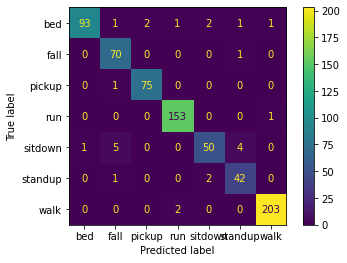

In [38]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(np.argmax(y_valid, axis=1), np.argmax(y_pred, axis=1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["bed", "fall", 
                                                                                                   "pickup", "run", 
                                                                                                   "sitdown", "standup", "walk"])

cm_display.plot()
plt.show()